In [48]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
from importlib import reload
from tqdm import tqdm

In [49]:
def get_Nl(noise_props, lmax):
    depth_ukarcmin, knee, alpha = noise_props
    n = (np.pi/(180*60) * depth_ukarcmin)**2
    l = np.arange(lmax+1)
    
    if knee !=0 and alpha != 0:
        Nl = n * (l/knee)**alpha + n
    else:
        Nl = n * np.ones(len(l))
        
#     if beam_fwhm != 0:
#         Nl *= np.exp(l*(l+1) * beam_fwhm **2 / 8/np.log(2))
        
    Nl[0] = 0 
    Nl[1] = 0 
    
    return Nl

In [50]:
nside = 512
npix = 12*nside**2
lmax = 3*nside-1
l = np.arange(lmax+1)
c2d = l*(l+1) / 2 /np.pi

In [51]:
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]

planck_T_noise_props = [25, 50, -1.8]
planck_P_noise_props = [50, 20, -1.4]

lb_T_noise_props = [1.25, 0, 0]
lb_P_noise_props = [2.5, 0, 0]

so_pol = get_Nl([3.3, 50, -3], lmax)
s4_pol = get_Nl([1, 50, -2], lmax)

Nl_T_planck = get_Nl(planck_T_noise_props, lmax)
Nl_P_planck = get_Nl(planck_P_noise_props, lmax)
Nl_T_lb = get_Nl(lb_T_noise_props, lmax)
Nl_P_lb = get_Nl(lb_P_noise_props, lmax)

planck_noise_cls = np.array([Nl_T_planck, Nl_P_planck, Nl_P_planck, np.zeros(lmax+1)])
lb_noise_cls = np.array([Nl_T_lb, Nl_P_lb, Nl_P_lb, np.zeros(lmax+1)])

fwhm = np.deg2rad(7.27/60) #planck 144ghz
bl = hp.gauss_beam(fwhm, lmax) #sat 

/tmp/ipykernel_39956/91691563.py:3: RuntimeWarning: invalid value encountered in divide
  input_cls /= ell_input*(ell_input+1)/2/np.pi
/tmp/ipykernel_39956/2002155264.py:7: RuntimeWarning: divide by zero encountered in power
  Nl = n * (l/knee)**alpha + n


(2, 1535)

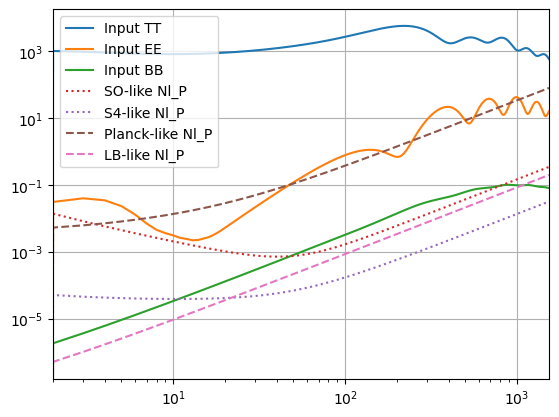

In [52]:
plt.plot(c2d*input_cls[0], label='Input TT')
plt.plot(c2d*input_cls[1], label='Input EE')
plt.plot(c2d*input_cls[2], label='Input BB')

plt.plot(c2d*so_pol, label='SO-like Nl_P', linestyle='dotted')
plt.plot(c2d*s4_pol, label='S4-like Nl_P', linestyle='dotted')

# plt.plot(c2d*planck_noise_cls[0], label='planck Nl_T', linestyle='dashed')
plt.plot(c2d*planck_noise_cls[1], label='Planck-like Nl_P', linestyle='dashed')

# plt.plot(c2d*lb_noise_cls[0], label='lb Nl_T', linestyle='dashed')
plt.plot(c2d*lb_noise_cls[1], label='LB-like Nl_P', linestyle='dashed')

# plt.plot(c2d*Nl_P_test)
# plt.plot(c2d*(input_cls+sat_noise_cls)[0], label='out TT')
# plt.plot(c2d*(input_cls+sat_noise_cls)[1], label='out EE')
# plt.plot(c2d*(input_cls+sat_noise_cls)[2], label='out BB')

plt.loglog()
plt.grid()
plt.legend()
# plt.ylim([5e-5, 1e4])
plt.xlim([2, lmax])

In [43]:
sat_noise_cls = lb_noise_cls

signal_cl = input_cls*bl**2
full_cl = input_cls*bl**2 + sat_noise_cls
W_11 = (signal_cl[1] * full_cl[0] - signal_cl[3]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
W_01 = (signal_cl[3] * full_cl[1] - signal_cl[1]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)

/tmp/ipykernel_39956/1358030064.py:5: RuntimeWarning: invalid value encountered in divide
  W_11 = (signal_cl[1] * full_cl[0] - signal_cl[3]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
/tmp/ipykernel_39956/1358030064.py:6: RuntimeWarning: invalid value encountered in divide
  W_01 = (signal_cl[3] * full_cl[1] - signal_cl[1]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)


[]

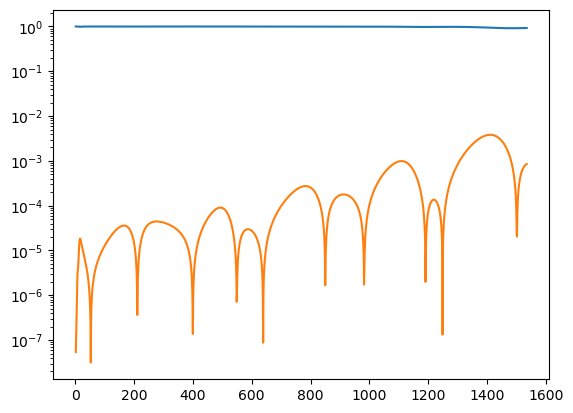

In [44]:
plt.plot(W_11, label='11 (EE)')
plt.plot(np.abs(W_01), label='01 (ET)')
plt.semilogy()

In [45]:
nmc = 100 

power_ratio_arr = np.empty((nmc, lmax+1))
signal_ratio_arr = np.empty((nmc, lmax+1))
noise_ratio_arr = np.empty((nmc, lmax+1))

for i in tqdm(range(nmc)):
    m_in= hp.synfast(input_cls, nside, fwhm=fwhm,new=True)
    m_res = hp.synfast(sat_noise_cls, nside, new=True)
    m_out= m_in + m_res
    
    alm_in = hp.map2alm(m_in)
    alm_res = hp.map2alm(m_res)
    alm_out = hp.map2alm(m_out)

    EE_contr = hp.almxfl(alm_out[1], W_11)
    TT_contr = hp.almxfl(alm_out[0], W_01)
    EE_contr_s = hp.almxfl(alm_in[1], W_11)
    TT_contr_s = hp.almxfl(alm_in[0], W_01)
    EE_contr_n = hp.almxfl(alm_res[1], W_11)
    TT_contr_n = hp.almxfl(alm_res[0], W_01)
    
    power_ratio_arr[i] = hp.alm2cl(EE_contr + TT_contr)/signal_cl[1]
    signal_ratio_arr[i] = (hp.alm2cl(EE_contr, EE_contr_s) + hp.alm2cl(TT_contr, TT_contr_s)) / signal_cl[1]
    noise_ratio_arr[i] = (hp.alm2cl(EE_contr, EE_contr_n) + hp.alm2cl(TT_contr, TT_contr_n)) / signal_cl[1]

power_ratio = np.mean(power_ratio_arr, axis=0)
signal_ratio = np.mean(signal_ratio_arr, axis=0)
noise_ratio = np.mean(noise_ratio_arr, axis=0)

100%|█████████████████████████████████████████| 100/100 [48:18<00:00, 28.98s/it]


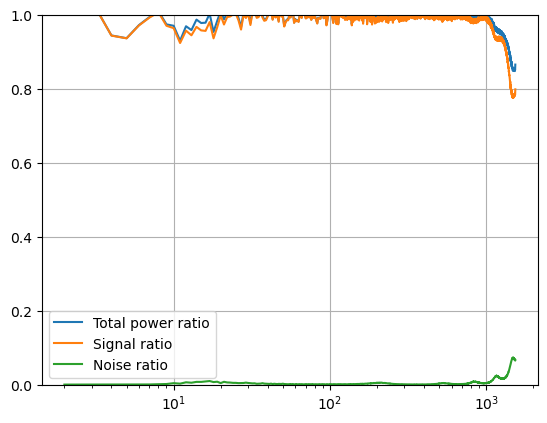

In [46]:
plt.plot(power_ratio, label='Total power ratio')
plt.plot(signal_ratio, label='Signal ratio')
plt.plot(noise_ratio, label='Noise ratio')

plt.legend()
plt.ylim([0,1])
plt.semilogx()
plt.grid()